In [2]:
import gc
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn as nn
import sys
from model.resnet50model import ResNet50
from modelbuilder import ModelBuilder
from utils import MetricCollector, plot_summary, mem_start, mem_end
plt.style.use('default')

In [4]:
# Отключаем средства дебаггинга
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [69]:
PATH = 'C:/Users/Artem/Desktop/Data_Science/My_programms/BoostResNet DL course project/src/baseline/data'
BATCH_SIZE = 512
LR = 0.001
WEIGHT_DECAY = 5e-4
EPOCHS = 4 #maximum iterations before stopping train layer
USE_AMP = True
BLOCKS = 17

In [6]:
# Определим устройство
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
print("Using {} device".format(device))

Using cuda device


### Загрузим датасеты    
Определим конвейер преобразования изображений

In [43]:
transform_train = transforms.Compose([
                            transforms.RandomCrop(32, padding=4),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])])

transform_test = transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])])

Загрузим датасет CIFAR-10

In [44]:
# Загрузим датасет CIFAR-10 train
cifar_train = torchvision.datasets.CIFAR10(root=PATH, 
                                           train=True, 
                                           download=True, 
                                           transform=transform_train)

Files already downloaded and verified


In [45]:
# test cifar
cifar_test = torchvision.datasets.CIFAR10(root=PATH, 
                                          train=False, 
                                          download=True, 
                                          transform=transform_test)

Files already downloaded and verified


Загрузим датасет SVHN

In [8]:
# train
dataset_svhn = torchvision.datasets.SVHN(root=f'{PATH}/svhn', 
                                         split='train', 
                                         download=True, 
                                         transform=transform_test)

Using downloaded and verified file: C:/Users/Artem/Desktop/Data_Science/My_programms/BoostResNet DL course project/src/baseline/data/svhn\train_32x32.mat


In [9]:
# test
svhn_test = torchvision.datasets.SVHN(root=f'{PATH}/svhn', 
                                      split='test', 
                                      download=True, 
                                      transform=transform_test)

Using downloaded and verified file: C:/Users/Artem/Desktop/Data_Science/My_programms/BoostResNet DL course project/src/baseline/data/svhn\test_32x32.mat


In [10]:
# разделим датасет svhn
val_size = 12000
train_size = len(dataset_svhn)  - val_size

In [11]:
train_svhn, val_svhn = random_split(dataset_svhn, [train_size, val_size])

### Подготовим загрузчики

In [46]:
# CIFAR-10
train_loader_cifar = DataLoader(cifar_train, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True,
                                num_workers=2,
                                pin_memory=True)

val_loader_cifar = DataLoader(cifar_test, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=2,
                              pin_memory=True)

In [12]:
# SVHN
# SVHN
train_loader_svhn = DataLoader(train_svhn, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               num_workers=2,
                               pin_memory=True)

val_loader_svhn = DataLoader(val_svhn, 
                             batch_size=BATCH_SIZE, 
                             num_workers=2,
                             pin_memory=True)

In [47]:
for X, y in train_loader_cifar:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([512, 3, 32, 32])
Shape of y:  torch.Size([512]) torch.int64


### Загружаем обучаемую модель ResNet50 

In [70]:
model = ResNet50().to(device)

In [71]:
loss_fn = torch.nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

Разложим модель на составные части

In [72]:
# Создадим словарь из блоков обучаемой модели
AllBlocks = {}
AllBlocks[0] = nn.Sequential(model.conv1, model.bn1, nn.ReLU())
for i in range(3): AllBlocks[1 + i] = model.layer1[i] 
for i in range(4): AllBlocks[4 + i] = model.layer2[i] 
for i in range(6): AllBlocks[8 + i] = model.layer3[i]
for i in range(3): AllBlocks[14+ i] = model.layer4[i]


In [73]:
collector = MetricCollector(BLOCKS, EPOCHS)

In [74]:
mem_start()
for n in range(BLOCKS):
    
    ModelTmp = ModelBuilder(model, AllBlocks, n)
    ModelTmp = ModelTmp.to(device)
    optimizer = torch.optim.AdamW(ModelTmp.parameters())
    
    for epoch in range(EPOCHS):
        train_err = 0
        acc_train = 0 
        num_correct_train = 0
        num_examples_train = 0
        model.train()
        for batch in train_loader_cifar:
            X, y = batch
            X, y = X.to(device), y.to(device)

            for i in range(n): 
                X = AllBlocks[i](X)
            
            with torch.autocast(device_type=device, dtype=torch.float16):
                output = ModelTmp(X)
                loss = loss_fn(output, y)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Посчитаем ошибку
            train_err += loss.item() * X.size(0)
            
            # Запишем ошибку
            collector.train_batch_error.append(loss.item())

            # Посчитаем точность
            correct = torch.sum(torch.eq(torch.max(output, dim=1)[1], y)).item()
            num_examples = X.shape[0]
            # Запишем точность
            collector.train_batch_acc.append(correct / num_examples)
            
            num_correct_train += correct
            num_examples_train += num_examples
            
            # Сброс градиентов
            for param in ModelTmp.parameters():
                param.grad = None
            
        acc_train = num_correct_train / num_examples_train
        train_err /= len(train_loader_cifar.dataset)
        
        # Добавим полученные значения в коллектор
        collector.train_acc[n][epoch] = acc_train
        collector.train_err[n][epoch] = train_err
            
        # посчитаем ошибку и точность на валидационном множестве
        model.eval()
        valid_err = 0
        acc_val = 0
        num_correct_val = 0
        num_examples_val = 0
        with torch.no_grad():
            for batch in val_loader_cifar:
                X, y = batch
                X, y = X.to(device), y.to(device)
    
                for i in range(n): 
                    X = AllBlocks[i](X)
                
                output = ModelTmp(X)
                loss = loss_fn(output, y)
                # Посчитаем ошибку
            
                valid_err += loss.item() * X.size(0)
                collector.val_batch_error.append(loss.item())
            
                # Посчитаем точность
                correct = torch.sum(torch.eq(torch.max(output, dim=1)[1], y)).item()
                num_examples = X.shape[0]
                collector.val_batch_acc.append(correct / num_examples)
                
                num_correct_val += correct
                num_examples_val += num_examples
        
        acc_val = num_correct_val / num_examples_val
        valid_err /= len(val_loader_cifar.dataset)
        
        # Добавим полученные значения в коллектор    
        collector.val_acc[n][epoch] = acc_val
        collector.val_err[n][epoch] = valid_err 

    for param in ModelTmp.parameters():
        param.grad = None
    ModelTmp.head = None
    gc.collect()
    torch.cuda.empty_cache()
    # Выведем итоговые результаты для блока
    train_acc, train_err, val_acc, val_err = collector.summary_block(n)  
            
    print(f"Block: {n}, Train Error: {train_err:0.3f}, Train Acc: {train_acc:0.3f},"
          f"Valid Error: {val_err:0.3f}, Valid Acc: {val_acc:0.3f}")

mem_end()


Block: 0, Train Error: 2.162, Train Acc: 0.215,Valid Error: 2.114, Valid Acc: 0.244
Block: 1, Train Error: 1.524, Train Acc: 0.470,Valid Error: 1.381, Valid Acc: 0.516
Block: 2, Train Error: 1.207, Train Acc: 0.580,Valid Error: 1.113, Valid Acc: 0.608
Block: 3, Train Error: 1.017, Train Acc: 0.647,Valid Error: 0.958, Valid Acc: 0.663
Block: 4, Train Error: 0.787, Train Acc: 0.733,Valid Error: 0.859, Valid Acc: 0.704
Block: 5, Train Error: 0.633, Train Acc: 0.783,Valid Error: 0.718, Valid Acc: 0.757
Block: 6, Train Error: 0.551, Train Acc: 0.812,Valid Error: 0.722, Valid Acc: 0.763
Block: 7, Train Error: 0.481, Train Acc: 0.835,Valid Error: 0.732, Valid Acc: 0.772
Block: 8, Train Error: 0.418, Train Acc: 0.858,Valid Error: 0.653, Valid Acc: 0.794
Block: 9, Train Error: 0.370, Train Acc: 0.873,Valid Error: 0.854, Valid Acc: 0.765
Block: 10, Train Error: 0.331, Train Acc: 0.886,Valid Error: 0.748, Valid Acc: 0.798
Block: 11, Train Error: 0.293, Train Acc: 0.899,Valid Error: 0.667, Valid A

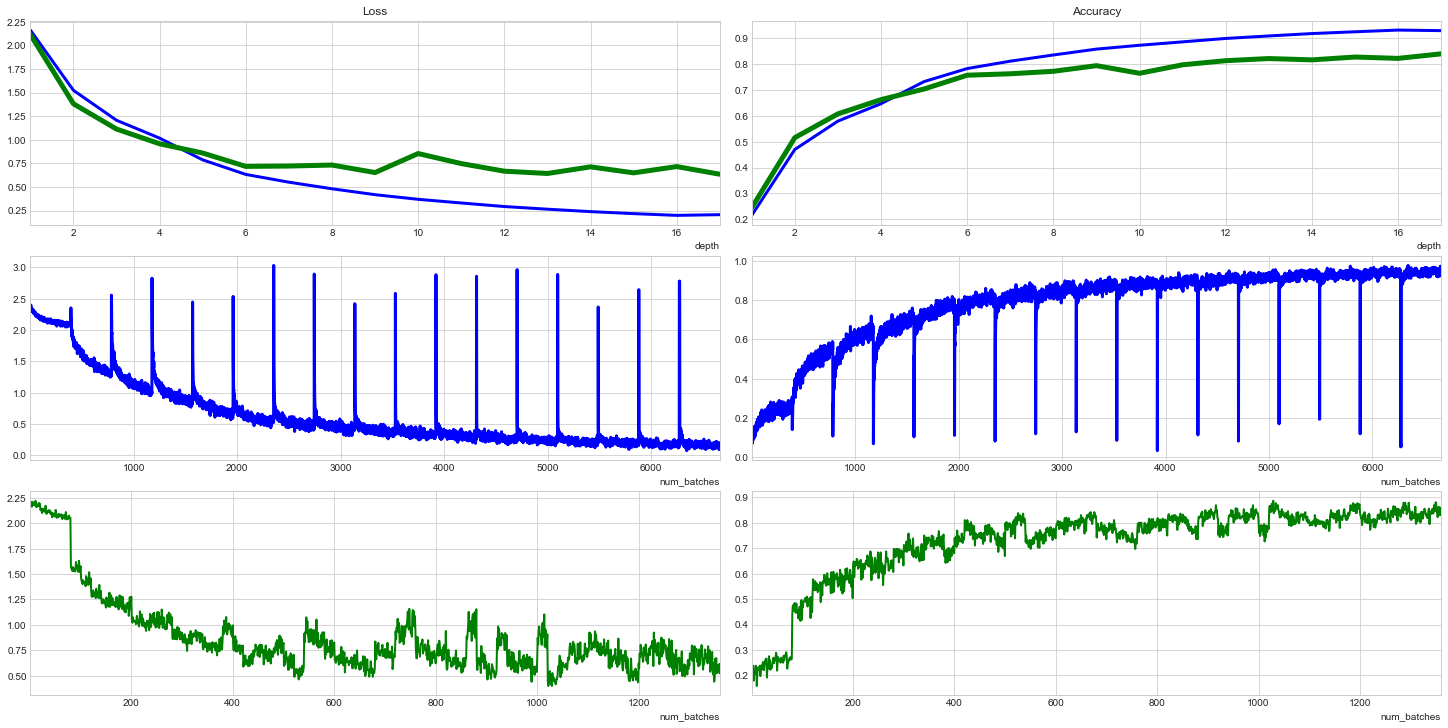

In [75]:
# Построим общий график для всей модели целиком
plot_summary(collector)

In [55]:
torch.save(model.state_dict(), 'brncifar1epoch')